# Calibration Project: Capital Flow Freezes ( Udara Peiris, 2024)

## Setup

### Packages

In [5]:
import requests
import pandas as pd
import xlrd
import os
import numpy as np

from scipy.optimize import fsolve
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt

### Path and working directory

In [6]:
ROOT = os.path.dirname(os.getcwd())

PATH_DATA = os.path.join(ROOT, 'data')

## External Estimation of Parameters

The income shocks $y_l$ and $y_h$ are computed based on GDP per capita growth between 1996 and 2000 in upper middle income countries like Argentina.

In [3]:
# open the excel file with the GDP growth data
df_growth = pd.read_excel(os.path.join(PATH_DATA, 'GDP_growth - world - WB.xls'), sheet_name=0, header=0)

# delete the first two rows
df_growth = df_growth.iloc[2:]

# Define the columns to keep
columns_to_keep = ['Country Name', 'Country Code', 'Indicator Name', "2001", "2002", "2003", "2004", "2005"]

df_growth=df_growth[columns_to_keep]

# Create a new column 'average' with the average of columns 2001, 2002, 2003, 2004, 2005 for each row
df_growth['average'] = df_growth[['2001', '2002', '2003', '2004', '2005']].mean(axis=1)

# Handle NaN values by dropping rows with NaN in the 'average' column
df_growth = df_growth.dropna(subset=['average'])

#open the excel file with the country income classification data
df_classification = pd.read_excel(os.path.join(PATH_DATA, 'World_Bank_classification.xlsx'), sheet_name=0, header=0)

#keep only the columns "Code" and "Income group"
df_classification = df_classification[['Code', 'Income group']]

# Merge the df_growth and df_classification DataFrames
df_merged = pd.merge(df_growth, df_classification, left_on='Country Code', right_on='Code')

# keep only if income group is "Upper middle income"
df_merged = df_merged[(df_merged['Income group'] == 'Upper middle income')]

# Find the percentile rank of the Argentinian average GDP growth
average_ARG = df_merged.loc[df_merged['Country Code'] == "ARG", 'average'].values
percentile_rank_ARG = percentileofscore(df_merged['average'], average_ARG)

# Calculate the high growth rate
growth_h = np.percentile(df_merged['average'], 100-percentile_rank_ARG/1.5)
            #ideally high growth rate would be symmetric to low growth rate,
            #but I need an higher high growth rate than the symmetric one

## Internal Calibration

In [87]:
class Udara_Peiris_economy:
    """
    This class represents the economy of Udara Peiris in which the private sector takes on some debt.
    If it is impacted by a negative income shock, it can pass on its debt to the sovereign, which
    will negotiate a haircut with creditors.

    Parameters:
        beta = time discount factor
        sigma = risk aversion coefficient
        g_l = growth rate in the low state
        g_h = growth rate in the high state
        y_0 = income in time 0
        y_l = low income in time 1 and 2
        g_h = high income in time 1 and 2
        kappa = loss of output if default  
    """
    def __init__(self,
                 beta=0.82,                             # time discount factor
                 sigma=2,                               # risk aversion
                 g_l=(1 + average_ARG / 100)**5 - 1,    # growth rate of the low state (example value)
                 g_h=(1 + growth_h / 100)**5 - 1,       # growth rate of the high state (example value)
                 y_0=1,                                 # output in time 0
                 kappa=0.32,                            # loss of output (quarterly 2%)
                 n_delta=101,                           # number of points in the grid for delta
                 n_theta=11):                           # number of points in the grid for theta

        # Calculate the low and high income in t=1 and t=2
        y_l = 1 + g_l
        y_h = 1 + g_h

        # Save parameters
        self.beta, self.sigma, self.kappa = beta, sigma, kappa
        self.g_l, self.g_h = g_l, g_h
        self.y_0, self.y_l, self.y_h = y_0, y_l, y_h
        self.n_delta, self.n_theta = n_delta, n_theta

        # Create grids
        self.delta_b = np.linspace(0, 1, n_delta)
        self.q_0 = beta * (1 - self.delta_b / 2)

        # Allocate memory
        self.b_0 = None

    # Household FOC for b_0
    def HH_foc_b0(self, b_0, delta_b, q_0):
        LHS = (2 - delta_b) * (self.y_0 + q_0 * b_0)**(-self.sigma)
        RHS_1 = (1 - delta_b) * (self.y_l + self.beta * (1 - delta_b) / (1 + self.beta) * b_0 - (1 - delta_b) * b_0)**(-self.sigma)
        RHS_2 = (self.y_h - b_0 / (1 + self.beta))**(-self.sigma)
        return LHS - RHS_1 - RHS_2

    # Vectorized function to solve for the root for each combination of delta_b and q_0
    def solve_for_roots(self):
        initial_guess = 0.5

        # Wrapper function for fsolve
        def wrapper(delta_b, q_0):
            return fsolve(self.HH_foc_b0, initial_guess, args=(delta_b, q_0))[0]

        # Apply the wrapper function to each combination of delta_b and q_0
        self.b_0 = np.array([wrapper(delta_b, q_0) for delta_b, q_0 in zip(self.delta_b, self.q_0)])
        return self.b_0
    
    # Plot b_0 as a function of delta_b
    def plot_b0_vs_delta_b(self):
        if self.b_0 is None:
            raise ValueError("You must calculate b_0 first by calling solve_for_roots().")
        
        # Create the plot
        plt.figure(figsize=(10, 6))
        plt.plot(self.delta_b, self.b_0, linestyle='-', color='b')
        plt.xlabel('delta_b')
        plt.ylabel('b_0')
        plt.title('b_0 as a function of delta_b')
        plt.grid(True)
        plt.show()
        
        # consumption in t=0
        self.c_0 = self.y_0 + self.q_0*self.b_0

    def trial(self):
        return self.c_0

        
    



Solutions for b_0: [0.15970039 0.16137707 0.16308039 0.16481083 0.16656892 0.16835516
 0.17017009 0.17201424 0.17388816 0.17579238 0.17772749 0.17969403
 0.18169259 0.18372375 0.18578809 0.18788622 0.19001874 0.19218625
 0.19438938 0.19662873 0.19890494 0.20121862 0.20357043 0.20596098
 0.20839092 0.21086088 0.2133715  0.21592342 0.21851726 0.22115366
 0.22383325 0.22655665 0.22932446 0.23213729 0.23499572 0.23790034
 0.24085171 0.24385037 0.24689685 0.24999164 0.25313523 0.25632805
 0.25957054 0.26286307 0.26620599 0.26959961 0.27304417 0.2765399
 0.28008696 0.28368544 0.28733539 0.29103679 0.29478954 0.29859347
 0.30244834 0.30635382 0.31030949 0.31431484 0.31836926 0.32247203
 0.32662234 0.33081926 0.33506173 0.33934859 0.34367855 0.3480502
 0.35246197 0.35691219 0.36139905 0.36592058 0.37047471 0.3750592
 0.37967168 0.38430965 0.38897049 0.39365141 0.39834953 0.40306183
 0.40778517 0.4125163  0.41725187 0.42198843 0.42672244 0.43145028
 0.43616826 0.44087264 0.44555962 0.45022537 0

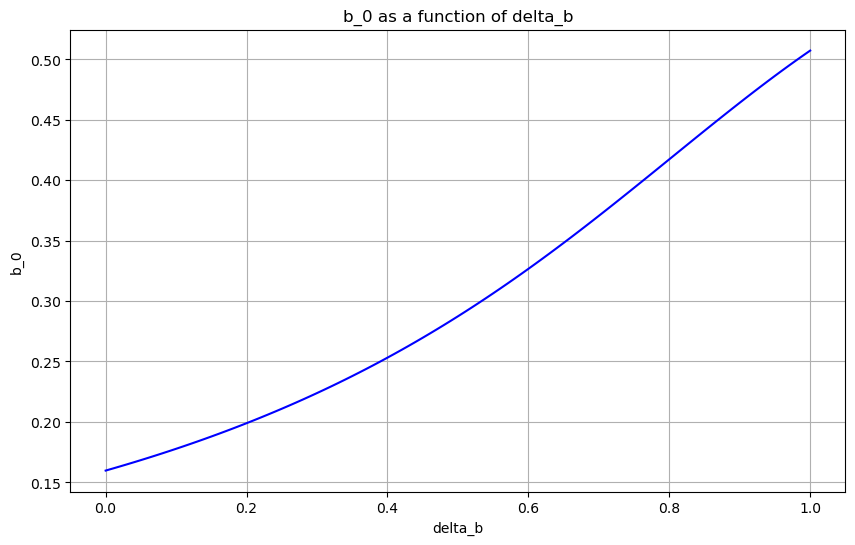

array([1.13095432, 1.13166755, 1.13238866, 1.13311771, 1.13385478,
       1.13459995, 1.13535329, 1.13611487, 1.13688476, 1.13766302,
       1.13844971, 1.1392449 , 1.14004865, 1.140861  , 1.141682  ,
       1.1425117 , 1.14335014, 1.14419735, 1.14505335, 1.14591818,
       1.14679184, 1.14767435, 1.1485657 , 1.14946588, 1.15037489,
       1.15129268, 1.15221923, 1.15315448, 1.15409837, 1.15505083,
       1.15601178, 1.1569811 , 1.15795869, 1.1589444 , 1.15993809,
       1.16093958, 1.16194869, 1.1629652 , 1.16398889, 1.16501948,
       1.16605671, 1.16710026, 1.1681498 , 1.16920496, 1.17026535,
       1.17133055, 1.17240009, 1.17347348, 1.17455019, 1.17562966,
       1.17671127, 1.17779437, 1.17887829, 1.17996228, 1.18104558,
       1.18212735, 1.18320672, 1.18428279, 1.18535458, 1.18642108,
       1.18748122, 1.18853389, 1.18957793, 1.1906121 , 1.19163516,
       1.19264578, 1.19364261, 1.19462422, 1.19558916, 1.19653595,
       1.19746302, 1.19836881, 1.1992517 , 1.20011004, 1.20094

In [88]:
economy = Udara_Peiris_economy()
b_0 = economy.solve_for_roots()
print("Solutions for b_0:", b_0)

economy.plot_b0_vs_delta_b()
